In [93]:
import sys
sys.path.insert(0, '../')
from lib.io_functions import load_npy, save_proccesed_variables
from lib.fit_functions import fit_wvfs
from lib.sim_functions import rand_scint_times
from lib.dec_functions import deconvolve

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [94]:
show = False
# Load data for wvf template
raw_SER = open("../larsoft/PDS/SPE_maritza.txt")
expand_array = 1000
# Generate empty array to import data
SER = []
for line in raw_SER.readlines():
    SER.append(float(line))
for i in np.zeros(expand_array):
    SER.append(i)
SER = np.array(SER)

# Generate dict with required structure
my_run = dict()

my_run["N_runs"] = [0]
my_run["N_channels"] = [0]

my_run[0] = dict()
my_run[0][0] = dict()
my_run[0][0]["ADC"] = [np.array(SER)]
my_run[0][0]["Sampling"] = 16e-9

if show == True:
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0])
    plt.show()
# print(my_run[0][0]["ADC"][0])

In [95]:
# One can substitute the template with a fit

# %matplotlib qt
OPT = {"SHOW": False}
fit_wvfs(my_run,"SC",1e-4,OPT=OPT)
max_idx = np.argmax(my_run[0][0]["Fit_SC"][0])
pre = len(my_run[0][0]["Fit_SC"][0][:max_idx])
post = len(my_run[0][0]["Fit_SC"][0][max_idx:])

if show == True:
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0])
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Fit_SC"][0])),my_run[0][0]["Fit_SC"][0])
    plt.show()

Fitting wvf  0




In [96]:
my_run[0][0]["MC_ADC"] = []
MC_num = 1000
for i in range(MC_num):
    times = rand_scint_times(N=50,slow=6e-9,fast=1e-6,ratio=0.15)
    peaks = [];wvf = []

    times_array = np.linspace(0,20e-6,int(20e-6/my_run[0][0]["Sampling"])+1)
    wvf = np.zeros(pre+len(times_array)+post)

    # print(len(wvf))
    for t in times:
        this_peak = int((t-(t%my_run[0][0]["Sampling"]))/my_run[0][0]["Sampling"])
        peaks.append(this_peak)
        this_wvf = np.zeros(pre+this_peak)
        this_wvf = np.append(this_wvf,my_run[0][0]["Fit_SC"][0])
        this_wvf = np.append(this_wvf,np.zeros(len(wvf)-len(this_wvf)))
        wvf = wvf+this_wvf
    my_run[0][0]["MC_ADC"].append(wvf)

# plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Fit_SC"][0])),my_run[0][0]["Fit_SC"][0])


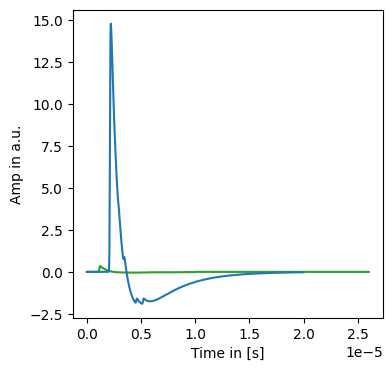

In [125]:
if show == True:
    plt.figure(figsize=(4,4))
    plt.xlabel("Time in [s]")
    plt.ylabel("Amp in a.u.")
    num = np.random.randint(0,MC_num)
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0],c="tab:green")
    plt.plot(times_array,my_run[0][0]["MC_ADC"][num][pre:-post])
    plt.show()

In [110]:
KEY = ["MC_ADC","ADC","Dec_ADC"]
OPT = {
    "NOISE_AMP": 1,
    "FIX_EXP":True,
    "LOGY":False,
    "NORM":True,
    "AUTO_TRIMM":True,
    "PRO_RODRIGO": False,
    "WIENER_BUFFER": 200,
    # "THRLD": 1e-4
    }
# print(my_run[0][0][KEY[1]][0])
deconvolve(my_run,my_run,my_run,KEY,OPT)

Generated wvfs with key Dec_ADC


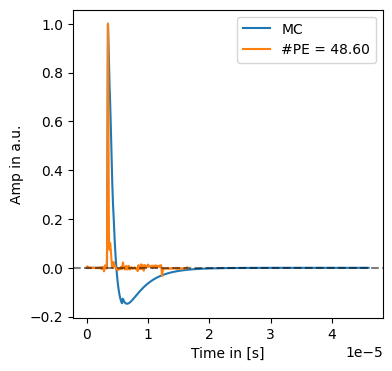

In [136]:
show = True
if show == True:
    plt.figure(figsize=(4,4))
    plt.xlabel("Time in [s]")
    plt.ylabel("Amp in a.u.")
    my_run[0][0].keys()
    num = np.random.randint(0,MC_num)
    charge = np.sum(my_run[0][0]["Dec_ADC"][num])
    norm = True
    if norm == True:
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["MC_ADC"][num])),my_run[0][0]["MC_ADC"][num]/np.max(my_run[0][0]["MC_ADC"][num]),label="MC")
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Dec_ADC"][num])),my_run[0][0]["Dec_ADC"][num]/np.max(my_run[0][0]["Dec_ADC"][num]),label="#PE = %.2f"%charge)
    else:
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["MC_ADC"][num])),my_run[0][0]["MC_ADC"][num],label="MC")
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Dec_ADC"][num])),my_run[0][0]["Dec_ADC"][num],label="#PE = %.2f"%charge)
    plt.axhline(0,ls="--",alpha=0.5,c="black")
    plt.legend()
    # plt.semilogy()
    plt.show()